## SITCOMTN_101 Fan cooling units (FCU) induced vibrations in M1M3

This notebook analyses data taken on December 7th, 2023 to check the vibrations induced by the Fan Cooling Units (FCU) on M1M3.
During the test, the fan speed varied from 0% up to 100% of the maximum speed (2550 rpm according to Petr Kubanek).
The description of the FCU system is available in [SPIE 77331E](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/7733/77331E/LSST-primarytertiary-mirror-thermal-control-system/10.1117/12.857438.short)

The notebook has originally been developped by Peter Ferguson.
In this new vesion we choose to measure the PSD acceleration and displacement independently for the 3 axes (x, y, z) of the accelerometers instead of considering the norm of the acceleration vector. 

We also check that during each measurement the mirror was raised and stable.

In [2]:
import sys, time, os, asyncio
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy import signal
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from matplotlib.ticker import FormatStrFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import ticker

from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, clipDataToEvent, calcNextDay

from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, TMAEvent
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst.ts.xml.enums import MTM1M3

%matplotlib inline
%load_ext autoreload
%autoreload 
%config Completer.use_jedi = False

In [3]:
# Utility functions
key_m1m3_dict={'1 X': 'm1m3_x_1', 
            '1 Y': 'm1m3_y_1', 
            '1 Z': 'm1m3_z_1', 
            '2 X': 'm1m3_x_2', 
            '2 Y': 'm1m3_z_2', # note these two have been 
            '2 Z': 'm1m3_y_2', # switched pending SUMMIT-7911
            '3 X': 'm1m3_x_3', 
            '3 Y': 'm1m3_y_3', 
            '3 Z': 'm1m3_z_3'
            }
key_m2_dict={'1 X': 'm2_x_1', 
            '1 Y': 'm2_y_1', 
            '1 Z': 'm2_z_1', 
            '2 X': 'm2_x_2', 
            '2 Y': 'm2_z_2', 
            '2 Z': 'm2_y_2', 
            '3 X': 'm2_x_3', 
            '3 Y': 'm2_z_3', 
            '3 Z': 'm2_y_3', 
            '4 X': 'm2_x_4', 
            '4 Y': 'm2_y_4', 
            '4 Z': 'm2_z_4', 
            '5 X': 'm2_x_5', 
            '5 Y': 'm2_z_5', 
            '5 Z': 'm2_y_5',
            '6 X': 'm2_x_6', 
            '6 Y': 'm2_z_6', 
            '6 Z': 'm2_y_6', 
            }
def vms_data_to_pandas(filename, vms_type, begin_time=None, end_time=None):
    """
    Converts VMS data in the given HDF5 file to a Pandas DataFrame.

    Args:
    filename: Path to the HDF5 file containing the VMS data.
    vms_type: The type of VMS data in the file. Must be "m1m3", "m2", or
      "rotator".
    begin_time: The start time of the data to include in the DataFrame. If None,
      all data will be included.
    end_time: The end time of the data to include in the DataFrame. If None, all
      data will be included.

    Returns:
    A Pandas DataFrame containing the VMS data.
    """
    if vms_type == "m1m3":
        key_dict=key_m1m3_dict
    elif vms_type=="m2":
        key_dict=key_m2_dict
    elif vms_type=="rotator":
        raise NotImplementedError
    else:
        raise ValueError('vms_type must be m1m3,m2, or rotator')

    f = h5py.File(filename, 'r')
    times = f['timestamp'][::1]
    dkeys = 'XYZ'
   
    data_dict = {}
    if (begin_time is not None) & (end_time is not None): 
        sel = (times > begin_time) & (times < end_time)
    else: 
        sel = np.ones(times.size).astype(bool)
    data_dict['times'] = times[sel]  
    for key in key_dict.keys():
        # multiply values stored in hdf5 files by 2 in order to convert the acceleration values to mg
        data_dict[key_dict[key]] = f[key][::1][sel]*2.
    data_frame = pd.DataFrame(data_dict)
    for j in np.arange(int(len(key_dict)/3)) +1:
        data_frame[f"total_{j}"] = np.linalg.norm(
            data_frame[[f"{vms_type}_{i}_{j}" for i in ["x","y","z"]]].values, axis=1
        )
    
    
    return data_frame

def get_freq_psd(vals, timestep):

    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.

    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.

    N = len(signal)

    # Calculate the power spectral density.

    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.

    frequencies = np.fft.rfftfreq(N, timestep)
    return (frequencies, psd)
    
def get_psd_and_dsd_for_vms(vals, timestep, min_freq=1, g=False):
    """
    Calculate the PSD and DSD from VMS data, and total displacement from DSD.

    Parameters:
    - vals (array-like): VMs in m/s^2 or milli-g if 'g' is True.
    - timestep (float): Time step between measurements in seconds.
    - min_freq (float, optional): Minimum frequency for calculations.
                                  Default is 1 Hz.
    - g (bool, optional): True if 'vals' are in milli-g units.
                          Default is False.

    Returns:
    - psds_df (DataFrame): DataFrame with frequencies ('freq'), acceleration
                           PSD ('accel_psd'), displacement PSD ('disp_psd'),
                           and cumulative displacement PSD ('int_disp').
    - total_displacement (float): Total displacement from vibration data.

    Note:
    PSD adjusted to m/s^2/Hz. 'vals' converted to m/s^2 if 'g' is True.
    """
    if g:
        vals = 1e-3 * 9.8 * vals

    #freq, accel_psd = signal.periodogram(vals, 1/timestep)
    #print("using scipy")
    freq, accel_psd = get_freq_psd(vals, timestep)

    sel = (freq > min_freq)
    freq = freq[sel]
    accel_psd = accel_psd[sel]

    accel_psd = accel_psd * np.mean(np.diff(freq))

    disp_psd_sq = accel_psd / ((2 * np.pi * freq) ** 4)

    int_displace_psd = np.sqrt(np.cumsum(disp_psd_sq))
    total_displacement = np.sqrt(np.sum(disp_psd_sq))

    psds_df = pd.DataFrame({"freq": freq, "accel_psd": accel_psd, 
                            "disp_psd": np.sqrt(disp_psd_sq),
                            "int_disp": int_displace_psd,
                           })
    
    return psds_df, total_displacement

In [4]:
#table="lsst.sal.MTM1M3.accelerometerData"
#begin_time=Time('2023-12-07 14:40:00.00')
#end_time=Time('2023-12-07 14:40:05.00')
#client = EfdClient("usdf_efd")

# hdf5 file containing the accelerometer data
vms_m1m3_filename="/sdf/data/rubin/shared/mtm1m3_test_files/vms_data/2023/12/M1M3-2023-12-07T00:00.hdf"

In [5]:
# Create a directory to save plots

plot_dir = "./plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Analyse data corresponding to the various FCU speeds
1. Read in CSV of timestamps, file `fcu_timestamps-corrected.csv` is attached to ticket sitcom 1131 (an embeded version is also provided for convenience)
2. Check mirror position and stability
3. Plot of all sensors acceleration PSD for every axis and for all fan states
4. Plot of all sensors displacement PSD for every axis and for all fan states

In [6]:
# For convenience and in order for this notebook to be able to run without copying data from somewhere else
# the content of the original csv file is loaded here as a dictionnary
# The fcu_state corresponds to the fan speed expressed as a percentage of the maximum speed
# The 2 other columns contain the timestamps corresponding to the beginning and end of a given measurement period with the fans running at a constant speed.

fcu_timestamps = {"fcu_state":[0, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                  " begin":["2023-12-07 14:20:00.00", "2023-12-07 14:33:00.00", "2023-12-07 14:55:30.00", "2023-12-07 15:00:05.00", "2023-12-07 15:05:05.00",
                           "2023-12-07 15:12:30.00", "2023-12-07 15:16:15.00", "2023-12-07 15:21:40.00", "2023-12-07 15:26:05.00", "2023-12-07 15:31:05.00",
                           "2023-12-07 17:48:55.00", "2023-12-07 17:51:30.00"],
                  " end":["2023-12-07 14:30:00.00", "2023-12-07 14:45:00.00", "2023-12-07 14:59:55.00", "2023-12-07 15:04:00.00", "2023-12-07 15:10:00.00",
                         "2023-12-07 15:14:30.00", "2023-12-07 15:20:00.00", "2023-12-07 15:25:00.00", "2023-12-07 15:30:00.00", "2023-12-07 15:40:00.00",
                         "2023-12-07 17:50:10.00", "2023-12-07 17:53:00.00"]}

In [7]:
file_path = "fcu_timestamps-corrected.csv"  # Path to file with timestamps and FCU speeds
if os.path.exists(file_path):
    print(f"Reading time stamps and FCU speeds from file: {file_path}")
    fcu_times = pd.read_csv(file_path)
else:
    print("Reading time stamps and FCU speeds from dictionnary")
    fcu_times = pd.DataFrame(fcu_timestamps)
    
fcu_times=fcu_times.sort_values("fcu_state").reset_index(drop=True)

Reading time stamps and FCU speeds from dictionnary


# Create table with fan speed and data taking periods for technote 

In [8]:
header ="""|FCU state| Start Time             | End Time               |
+=========+========================+========================+"""
row_str="+---------+------------------------+------------------------+"


In [9]:
print(row_str)
print(header)
for i in range(len(fcu_times)):
    percentv,begin, end = fcu_times.iloc[i,:]
    print(f"| {percentv:7d} | {begin} | {end} |")
    print(row_str)

+---------+------------------------+------------------------+
|FCU state| Start Time             | End Time               |
+=========+========================+========================+
|       0 | 2023-12-07 14:20:00.00 | 2023-12-07 14:30:00.00 |
+---------+------------------------+------------------------+
|      10 | 2023-12-07 14:55:30.00 | 2023-12-07 14:59:55.00 |
+---------+------------------------+------------------------+
|      20 | 2023-12-07 15:00:05.00 | 2023-12-07 15:04:00.00 |
+---------+------------------------+------------------------+
|      30 | 2023-12-07 15:05:05.00 | 2023-12-07 15:10:00.00 |
+---------+------------------------+------------------------+
|      40 | 2023-12-07 15:12:30.00 | 2023-12-07 15:14:30.00 |
+---------+------------------------+------------------------+
|      50 | 2023-12-07 15:16:15.00 | 2023-12-07 15:20:00.00 |
+---------+------------------------+------------------------+
|      60 | 2023-12-07 15:21:40.00 | 2023-12-07 15:25:00.00 |
+-------

## Check that the TMA doesn't move during the vibration measurements

In [10]:
client = EfdClient("usdf_efd")

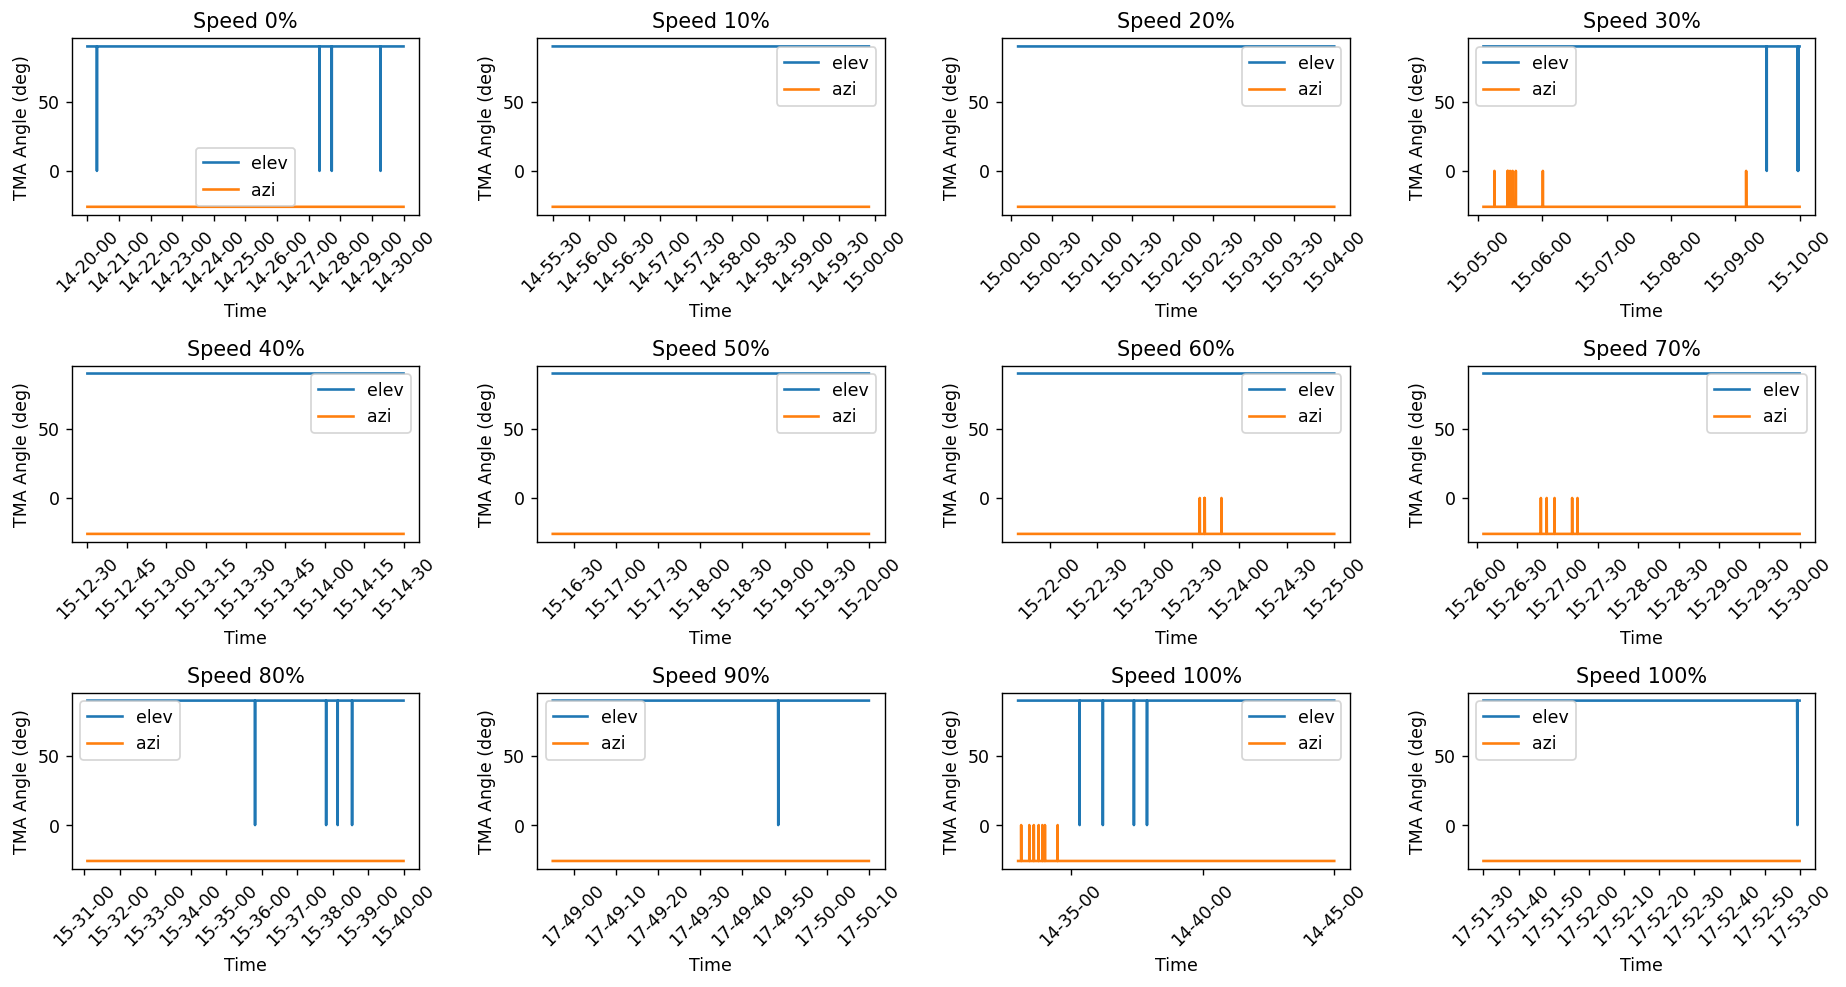

In [11]:
# Check whether the TMA stayed at the same azimuth and elevation during the vibration measurements
fig, ax = plt.subplots(3, 4,dpi=125,figsize=(15,8))
for i in range(len(fcu_times)):
    percentv,begin, end = fcu_times.iloc[i,:]
    begin=Time(begin)
    end=Time(end)
    # Get TMTMount Elevation data
    df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", begin=begin, end=end)
    # Get TMTMount Azimuth data
    df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", begin=begin, end=end)

    l = int(i/4)
    c = i%4
    _ = ax[l,c].plot(df_ele.index, df_ele["actualPosition"], label="elev")
    _ = ax[l,c].plot(df_azi.index, df_azi["actualPosition"], label="azi")
    ax[l][c].set(ylabel="TMA Angle (deg)", xlabel="Time", title=f"Speed {percentv}%")
    ax[l][c].legend()
   
    ax[l][c].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
    plt.setp(ax[l][c].get_xticklabels(), rotation = 45)

fig.tight_layout()
fig.savefig(plot_dir+"/TMA_position.png")

## Spikes
We see that the EFD MTMount.elevation and MTMount.azimuth topics exhibit several spikes where the TMA seems to jump from 89.95 deg to 0 deg 
in elevation and from -25.95 deg to 0 deg in azimuth. 

These spikes look suspiciously narrow and incompatible with an actual move of the TMA

Let's zoom in on one of these spikes

2023-12-07 14:33:00.000 2023-12-07 14:45:00.000


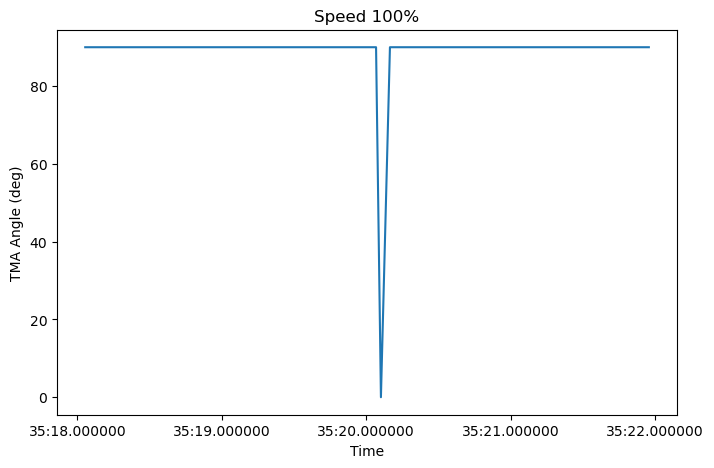

In [12]:
# Check whether the TMA is stable and at the same position during the vibration measurements
i = 10
fig, ax = plt.subplots(1,dpi=100,figsize=(8,5))
percentv,begin, end = fcu_times.iloc[i,:]
begin=Time(begin)
end=Time(end)
print(begin, end)
begin = Time("2023-12-07 14:35:18.000")
end = Time("2023-12-07 14:35:22.000")
# Get TMTMount Elevation data
df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", begin=begin, end=end)
# Get TMTMount Azimuth data
df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", begin=begin, end=end)

_ = ax.plot(df_ele.index, df_ele["actualPosition"], label="elev")
_ = ax.set(ylabel="TMA Angle (deg)", xlabel="Time", title=f"Speed {percentv}%")

fig.savefig(plot_dir+"/TMA_spike.png")

## Conclusion on the spikes and TMA position during vibration measurements

We clearly see that the spikes reported by the EFD cannot be associated to actual move of the TMA

We conclude that the TMA orientation in both azimuth and elevation was stable during the vibration measurements

## Check mirror position and stability during vibration measurements

In the following we check that :

 * the mirror is raised (MTM1M3.detailedStates == ACTIVEENGINEERING) and stable during each measurement period
 * the Hard Points are in standby state and stable during each measurement period

In [13]:
# Retrieve the M1M3 detailed states during a time period including the FCU tests
begin_time=Time('2023-12-07 12:00:00.00')
end_time=Time('2023-12-07 19:00:00.00')
det_state = getEfdData(client, "lsst.sal.MTM1M3.logevent_detailedState", begin=begin_time, end=end_time)
det_state["detailedStateName"] = \
    det_state["detailedState"].map(lambda x: MTM1M3.DetailedStates(x).name)

# Retrieve M1M3 Hard Point states during a time period including the FCU tests
hp_state = getEfdData(client, "lsst.sal.MTM1M3.logevent_hardpointActuatorState", begin=begin_time, end=end_time)

In [14]:
# Print all possible values of DetailedState because I always forget
list(MTM1M3.DetailedStates)

[<DetailedStates.DISABLED: 1>,
 <DetailedStates.FAULT: 2>,
 <DetailedStates.OFFLINE: 3>,
 <DetailedStates.STANDBY: 4>,
 <DetailedStates.PARKED: 5>,
 <DetailedStates.RAISING: 6>,
 <DetailedStates.ACTIVE: 7>,
 <DetailedStates.LOWERING: 8>,
 <DetailedStates.PARKEDENGINEERING: 9>,
 <DetailedStates.RAISINGENGINEERING: 10>,
 <DetailedStates.ACTIVEENGINEERING: 11>,
 <DetailedStates.LOWERINGENGINEERING: 12>,
 <DetailedStates.LOWERINGFAULT: 13>,
 <DetailedStates.PROFILEHARDPOINTCORRECTIONS: 14>,
 <DetailedStates.PAUSEDRAISING: 15>,
 <DetailedStates.PAUSEDRAISINGENGINEERING: 16>,
 <DetailedStates.PAUSEDLOWERING: 17>,
 <DetailedStates.PAUSEDLOWERINGENGINEERING: 18>]

In [40]:
header ="""|FCU state| Start Time              | End Time                | Detailed State    | Stable |
+=========+=========================+=========================+===================+========="""
row_str="+---------+-------------------------+-------------------------+-------------------+--------+"

print(header)
for i in range(len(fcu_times)):
    percentv,begin, end = fcu_times.iloc[i,:]
    begin=Time(begin)
    end=Time(end)
    # Find time stamp in det_state preceding the beginning of the FCU run
    iloc_begin_st = det_state.index.get_indexer([begin], method='pad')[0]
    # Find time stamp in det_state preceding the end of the FCU run
    iloc_end_st = det_state.index.get_indexer([end], method='pad')[0]
    if iloc_begin_st == iloc_end_st :
        stable = True
    else:
        stable = False
    state = det_state["detailedStateName"].iloc[iloc_end_st]
    #print(percentv, begin, end, state, stable)
    print(f"| {percentv:7d} | {begin} | {end} | {state} | {stable}   |")
    print(row_str)

|FCU state| Start Time              | End Time                | Detailed State    | Stable |
+=========+=========================+=========================+===================+=========
|       0 | 2023-12-07 14:20:00.000 | 2023-12-07 14:30:00.000 | ACTIVEENGINEERING | True   |
+---------+-------------------------+-------------------------+-------------------+--------+
|      10 | 2023-12-07 14:55:30.000 | 2023-12-07 14:59:55.000 | ACTIVEENGINEERING | True   |
+---------+-------------------------+-------------------------+-------------------+--------+
|      20 | 2023-12-07 15:00:05.000 | 2023-12-07 15:04:00.000 | ACTIVEENGINEERING | True   |
+---------+-------------------------+-------------------------+-------------------+--------+
|      30 | 2023-12-07 15:05:05.000 | 2023-12-07 15:10:00.000 | ACTIVEENGINEERING | True   |
+---------+-------------------------+-------------------------+-------------------+--------+
|      40 | 2023-12-07 15:12:30.000 | 2023-12-07 15:14:30.000 | ACTIVE

In [15]:
header ="""|FCU state| Start Time              | End Time                | HP Standby    | HP Stable |
+=========+=========================+=========================+===================+========="""
row_str="+---------+-------------------------+-------------------------+-------------------+--------+"

print(header)
for i in range(len(fcu_times)):
    percentv,begin, end = fcu_times.iloc[i,:]
    begin=Time(begin)
    end=Time(end)
    # Find time stamp in det_state preceding the beginning of the FCU run
    iloc_begin = hp_state.index.get_indexer([begin], method='pad')[0]
    # Find time stamp in det_state preceding the end of the FCU run
    iloc_end = hp_state.index.get_indexer([end], method='pad')[0]
    if iloc_begin == iloc_end :
        hp_stable = True
    else:
        hp_stable = False
    sub_hp_state = hp_state.iloc[iloc_end] 
    # Check whether the 6 HP are in STANDBY mode
    hp_standby = (sub_hp_state[[f"motionState{j}" for j in range(0, 6)]] == 0).sum() == 6
    #print(percentv, begin, end, state, stable)
    print(f"| {percentv:7d} | {begin} | {end} | {hp_standby}          | {hp_stable}       |")
    print(row_str)

|FCU state| Start Time              | End Time                | HP Standby    | HP Stable |
+=========+=========================+=========================+===================+=========
|       0 | 2023-12-07 14:20:00.000 | 2023-12-07 14:30:00.000 | True          | True       |
+---------+-------------------------+-------------------------+-------------------+--------+
|      10 | 2023-12-07 14:55:30.000 | 2023-12-07 14:59:55.000 | True          | True       |
+---------+-------------------------+-------------------------+-------------------+--------+
|      20 | 2023-12-07 15:00:05.000 | 2023-12-07 15:04:00.000 | True          | True       |
+---------+-------------------------+-------------------------+-------------------+--------+
|      30 | 2023-12-07 15:05:05.000 | 2023-12-07 15:10:00.000 | True          | True       |
+---------+-------------------------+-------------------------+-------------------+--------+
|      40 | 2023-12-07 15:12:30.000 | 2023-12-07 15:14:30.000 | True   

In [16]:
# Read data from hdf file into pandas
begin_time=Time(fcu_times[' begin'].min())
end_time=Time(fcu_times[' end'].max())
vms_m1m3_data=vms_data_to_pandas(vms_m1m3_filename, vms_type="m1m3",begin_time=begin_time.unix, end_time=end_time.unix)

In [17]:
print(begin_time, end_time)

2023-12-07 14:20:00.000 2023-12-07 17:53:00.000


## Check sampling rate

As we are going to estimate a PSD, it is important to check that the sampling rate is constant.
It is supposed to be equal to 200 Hz

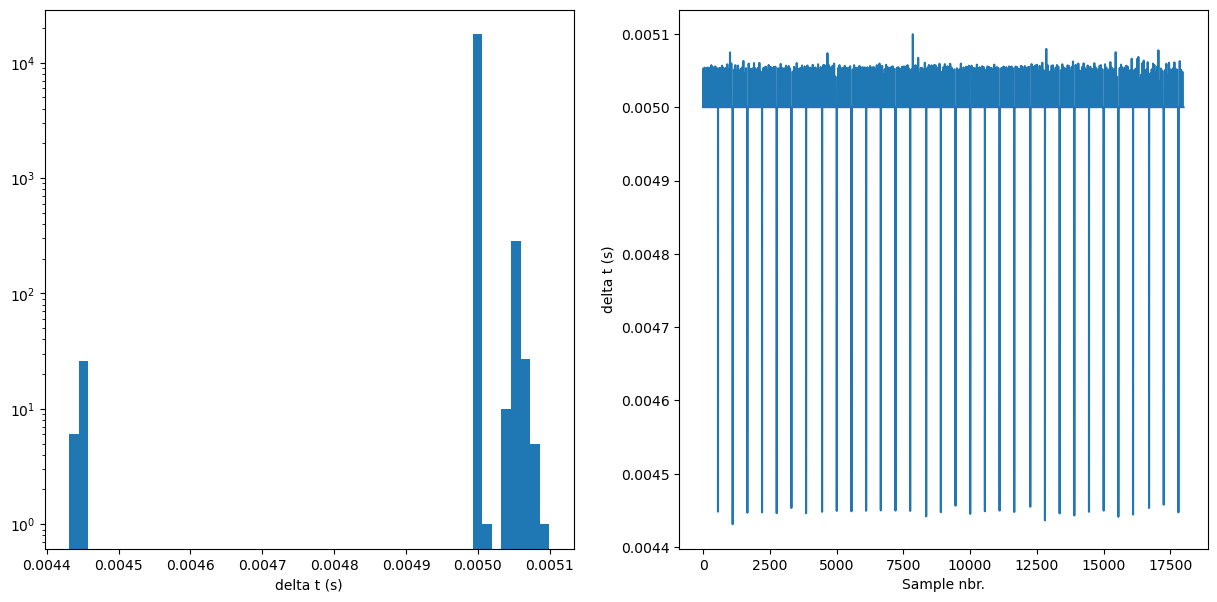

In [18]:
subdat_sel = (vms_m1m3_data["times"] > begin.unix) & (vms_m1m3_data["times"] < end.unix) 
subdat=vms_m1m3_data.loc[subdat_sel,:]
delta_t = np.diff(subdat["times"])

fig, ax = plt.subplots(1,2,dpi=100,figsize=(15,7))
_ = ax[0].hist(delta_t, bins=50)
ax[0].set_xlabel("delta t (s)")
ax[0].set_yscale("log")

sample = np.arange(len(delta_t))
_ = ax[1].plot(sample, delta_t)
ax[1].set_xlabel("Sample nbr.")
ax[1].set_ylabel("delta t (s)")

fig.savefig(plot_dir+"/sampling.png")

## Conclusion on the sampling rate

From the previous plots we see that the sampling rate is equal to ~200 Hz for most of the data samples but for a fraction of the samples the time difference between 2 consecutive 
samples is equal to ~0.00444 instead of 0,0050. On the right plot where these differences are plotted with respect to sampling number, one can see that these occurences are periodic. If real, this could potentially bias the PSD measurements, nevertheless from a discussion with Petr Kubanek it seems that the sampling rate is set to 200 Hz by the hardware and that the observed behavior is probably due to wrong timestamp.

This issue as been logged in ticket DM-43219

## PSD Analysis

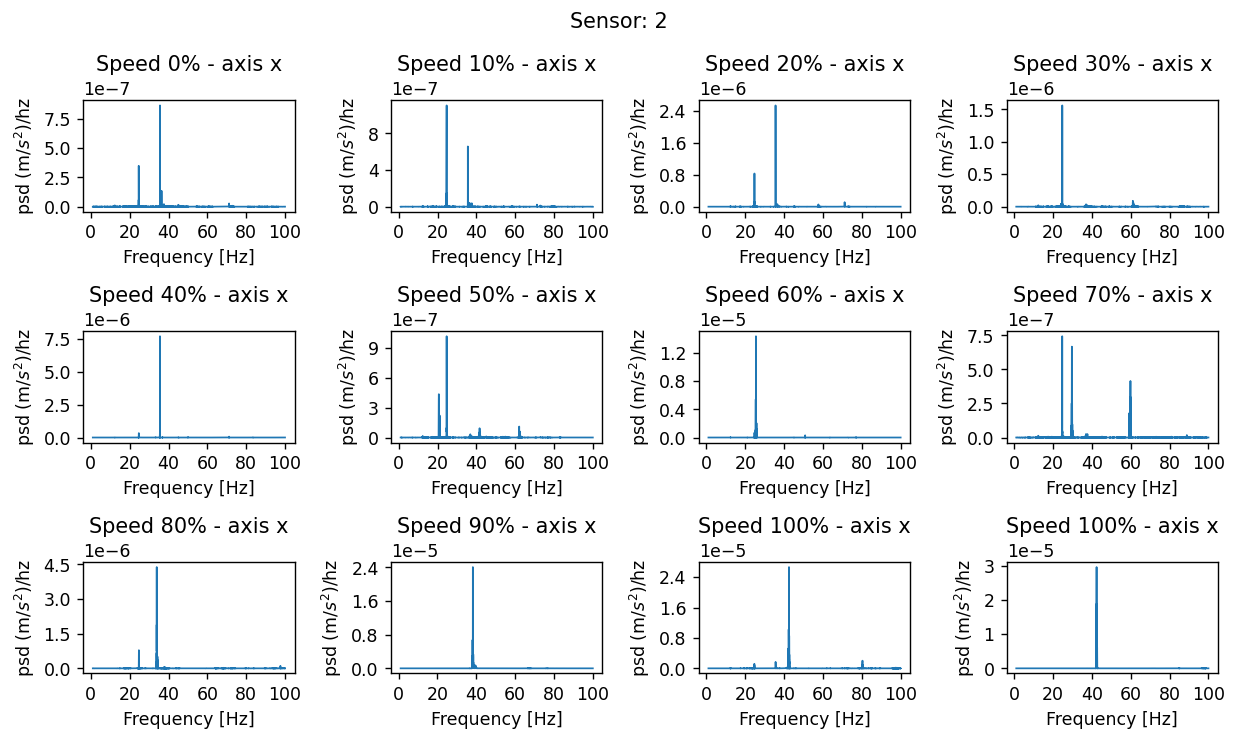

In [19]:
# PSD (acceleration) for a given sensor (1, 2, or 3), a given axis (x, y, z) and for each speed value (0% - 100%) 

fig, ax = plt.subplots(3, 4,dpi=125,figsize=(10,6))

sensor = 2 # Sensor number
axis = "x"

for i in range(12):
    percentv,begin, end = fcu_times.iloc[i,:]
    begin=Time(begin)
    end=Time(end)
    subdat_sel = (vms_m1m3_data["times"] > begin.unix) & (vms_m1m3_data["times"] < end.unix) 
    subdat=vms_m1m3_data.loc[subdat_sel,:]
    
    key= f"m1m3_{axis}_{sensor}"
    psds_df, disp =get_psd_and_dsd_for_vms(subdat[key], 
                                                np.mean(np.diff(subdat["times"])),
                                                g=True, min_freq=1)
    x = psds_df['freq']
    y = psds_df['accel_psd']
    l = int(i/4)
    c = i%4
    ax[l][c].plot(x,y, label=f"{percentv}%\n", zorder=9, lw=1)
    ax[l][c].set_xticks(np.arange(0,110,20))
    ax[l][c].set(ylabel="psd (m/$s^2$)/hz", xlabel="Frequency [Hz]", title=f"Speed {percentv}% - axis {axis}")
    yticks = ticker.MaxNLocator(4)
    ax[l][c].yaxis.set_major_locator(yticks)
    
fig.suptitle(f"Sensor: {sensor}")
fig.tight_layout()
plt.savefig(f"{plot_dir}/psd_sensor_{sensor}_axis_{axis}.png")

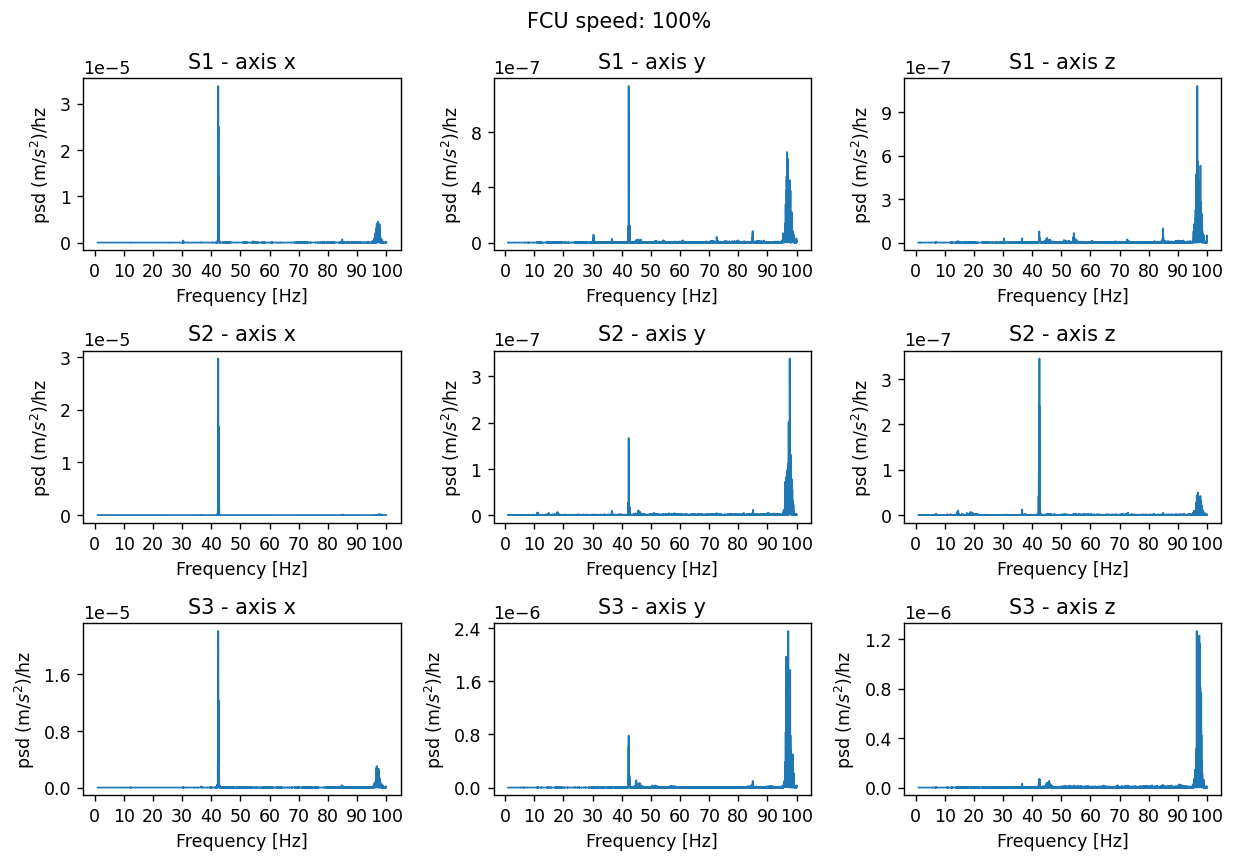

In [21]:
# Plot the PSD (aceleration) for each sensor, each axis and one given fan speed

i = 11 # Measurement number => check table of measurements above
fig, ax = plt.subplots(3, 3,dpi=125,figsize=(10,7))
for c in range(3):
    key=f"total_{c+1}"

    percentv,begin, end = fcu_times.iloc[i,:]
    begin=Time(begin)
    end=Time(end)
    subdat_sel = (vms_m1m3_data["times"] > begin.unix) & (vms_m1m3_data["times"] < end.unix) 
    subdat=vms_m1m3_data.loc[subdat_sel,:]
    for j, axis in enumerate("xyz"):
        key= f"m1m3_{axis}_{c+1}"
        psds_df, disp =get_psd_and_dsd_for_vms(subdat[key], 
                                                    np.mean(np.diff(subdat["times"])),
                                                    g=True, min_freq=1)
        x = psds_df['freq']
        y = psds_df['accel_psd']
        ax[c][j].plot(x,y, label=f"{percentv}%\n", zorder=9, lw=1)
        ax[c][j].set_xticks(np.arange(0,110,10))
        ax[c][j].set(ylabel="psd (m/$s^2$)/hz", xlabel="Frequency [Hz]", title=f"S{c+1} - axis {axis}")
        yticks = ticker.MaxNLocator(4)
        ax[c][j].yaxis.set_major_locator(yticks)
fig.suptitle(f"FCU speed: {percentv}%")
fig.tight_layout()
plt.savefig(f"{plot_dir}/psd_speed_{percentv}.png")

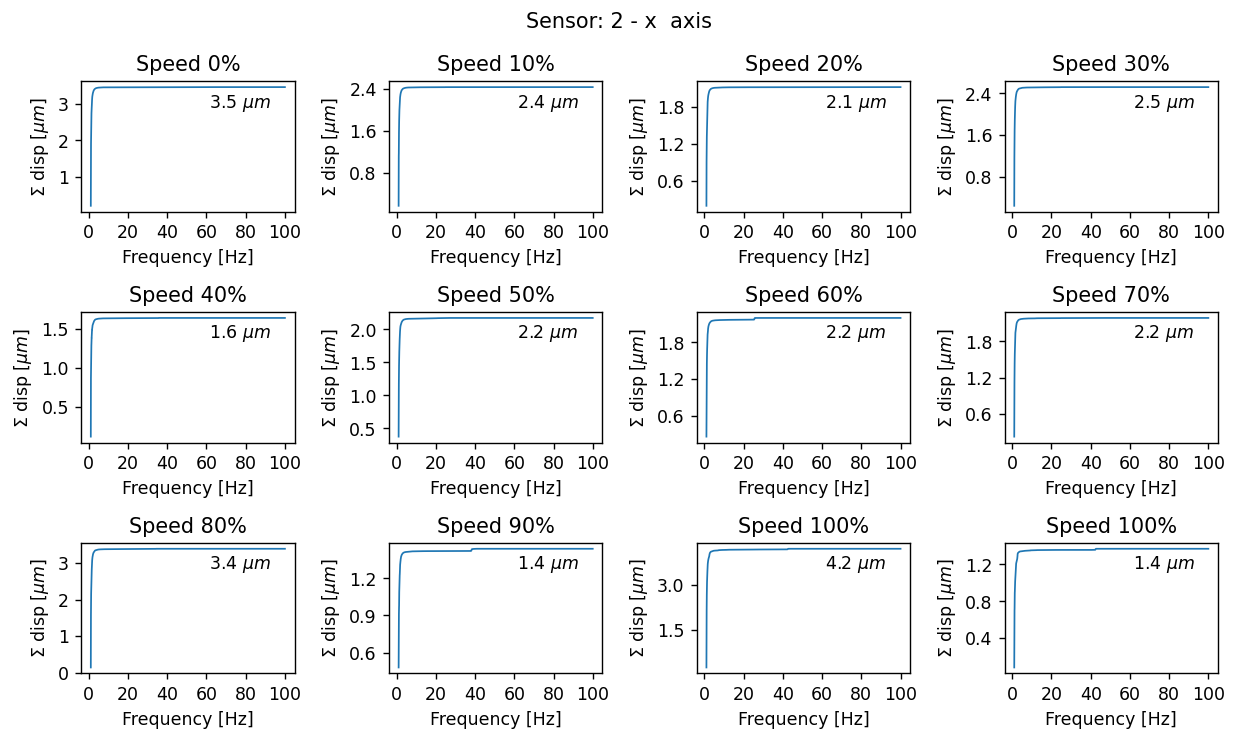

In [22]:
# Total (cumulative) displacement for a given sensor, a given axis and all the speed values

fig, ax = plt.subplots(3, 4,dpi=125,figsize=(10,6))

sensor = 2 # Sensor number
axis = "x"

for i in range(12):
    percentv,begin, end = fcu_times.iloc[i,:]
    begin=Time(begin)
    end=Time(end)
    subdat_sel = (vms_m1m3_data["times"] > begin.unix) & (vms_m1m3_data["times"] < end.unix) 
    subdat=vms_m1m3_data.loc[subdat_sel,:]
    
    #key = f"total_{sensor}"
    key= f"m1m3_{axis}_{sensor}"
    psds_df, tot_disp =get_psd_and_dsd_for_vms(subdat[key], 
                                                np.mean(np.diff(subdat["times"])),
                                                g=True, min_freq=1)
    x = psds_df['freq']
    y = psds_df['int_disp']*1.e6
    l = int(i/4)
    c = i%4
    ax[l][c].plot(x,y, label=f"{percentv}%\n", zorder=9, lw=1)
    ax[l][c].set_xticks(np.arange(0,110,20))
    ax[l][c].set(ylabel="$\Sigma$ disp [$\mu m$]", xlabel="Frequency [Hz]", title=f"Speed {percentv}%")
    ax[l,c].text(0.6, 0.8, "{:#.2g} $\mu m$".format(tot_disp*1.e6), transform=ax[l][c].transAxes)
    yticks = ticker.MaxNLocator(4)
    ax[l][c].yaxis.set_major_locator(yticks)
    
fig.suptitle(f"Sensor: {sensor} - {axis}  axis")
fig.tight_layout()
plt.savefig(f"{plot_dir}/psd_cumul_disp_sensor_{sensor}_axis{axis}.png")